---
title: In-window spike detection (UCI Air dataset, CO feature)
format:
  html:
    self-contained: true
    echo: false
    output: false
    page-layout: full
jupyter: python3
tbl-cap-location: margin
---

## Outline of experiment:

1. Load UCI Air dataset
2. Create combined datetime column (sequential timeframe)
3. Select a single sensor measurement variable (*CO*)
4. Define a window with width $W=8$
5. Calculate difference values between two timeframes
6. Determine if the value is an outlier in the window or not
7. If so and the value is positive, mark as an anomaly
8. Move the window by one frame
9. Predict if the new value is anomaly or not
10. Visualize all the collected anomalies for the entire data

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from datetime import date, datetime
from ucimlrepo import fetch_ucirepo
from IPython.display import Markdown as md

In [314]:
# dataset
air_quality = fetch_ucirepo(id=360) 
X = air_quality.data.features

# preprocessing

## column refinement
X['Date'] = pd.to_datetime(X['Date'], format='%m/%d/%Y').dt.date
X['Time'] = pd.to_datetime(X['Time'], format='%H:%M:%S').dt.time
X['Time_hour'] = [x.hour for x in X['Time']]
X['Datetime'] = pd.to_datetime(X['Date']) + pd.to_timedelta(X['Time_hour'], unit='h')

## select columns
X_filtered = X.loc[:499, ['Datetime', 'CO(GT)']].copy()
X_filtered.columns = ['Datetime', 'CO']

## window
WINDOW_WIDTH = 6

## impute missing values
X_filtered.loc[X_filtered['CO'] == -200, 'CO'] = np.nan
X_filtered.loc[X_filtered['CO'].isna(), 'CO'] = X_filtered['CO'].rolling(5, center=True, min_periods=1).mean()

assert not(X_filtered['CO'].isna().any())

## add diff column
X_filtered['CO_diff'] = X_filtered['CO'].diff()
X_filtered.loc[0, 'CO_diff'] = 0

In [315]:
def get_CO_at(t=0, w=WINDOW_WIDTH):
	datetime = X_filtered.loc[t:(t+w-1), 'Datetime'].copy()
	co = X_filtered.loc[t:(t+w-1), 'CO'].copy()

	return datetime, co

def get_CO_diff_at(t=0, w=WINDOW_WIDTH):
	datetime = X_filtered.loc[t:(t+w-1), 'Datetime'].copy()
	co_diff = X_filtered.loc[t:(t+w-1), 'CO_diff'].copy()

	return datetime, co_diff

## Portion of the transformed dataset

In [316]:
#| output: true
display(md("First 100 records of CO sensor measurements"))
display(X_filtered)

First 100 records of CO sensor measurements

,Datetime,CO,CO_diff
0,2004-03-10 18:00:00,2.6,0.0
1,2004-03-10 19:00:00,2.0,-0.6
2,2004-03-10 20:00:00,2.2,0.2
3,2004-03-10 21:00:00,2.2,0.0
4,2004-03-10 22:00:00,1.6,-0.6
...,...,...,...
495,2004-03-31 09:00:00,2.2,-1.9
496,2004-03-31 10:00:00,1.7,-0.5
497,2004-03-31 11:00:00,1.9,0.2
498,2004-03-31 12:00:00,2.9,1.0


## Example windows

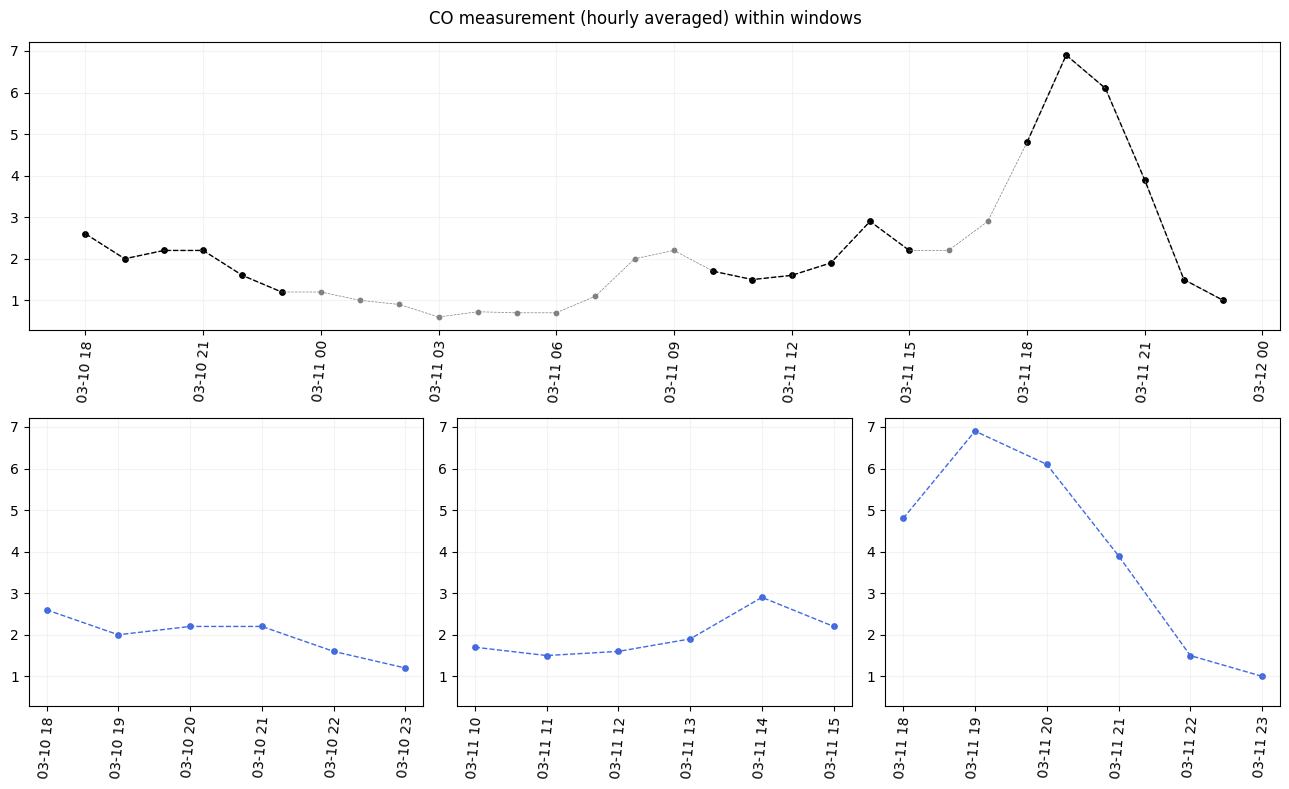

In [317]:
#| output: true

fig = plt.figure(figsize=(13, 8))
axes = []

ax = plt.subplot(211)
axes.append(ax)

dt, co = get_CO_at(0, 5*WINDOW_WIDTH)
ax.scatter(dt, co, s=10, color="grey")
ax.plot(dt, co, linewidth=.5, linestyle="dashed", color="grey")

dt, co = get_CO_at(0)
ax.scatter(dt, co, s=15, color="k")
ax.plot(dt, co, linewidth=1, linestyle="dashed", color="k")

dt, co = get_CO_at(WINDOW_WIDTH+10)
ax.scatter(dt, co, s=15, color="k")
ax.plot(dt, co, linewidth=1, linestyle="dashed", color="k")

dt, co = get_CO_at(4*WINDOW_WIDTH)
ax.scatter(dt, co, s=15, color="k")
ax.plot(dt, co, linewidth=1, linestyle="dashed", color="k")


ax = plt.subplot(234, sharey=axes[0])
axes.append(ax)
dt, co = get_CO_at(0)
ax.scatter(dt, co, s=15, color="royalblue")
ax.plot(dt, co, linewidth=1, linestyle="dashed", color="royalblue")

ax = plt.subplot(235, sharey=axes[0])
axes.append(ax)
dt, co = get_CO_at(WINDOW_WIDTH+10)
ax.scatter(dt, co, s=15, color="royalblue")
ax.plot(dt, co, linewidth=1, linestyle="dashed", color="royalblue")

ax = plt.subplot(236, sharey=axes[0])
axes.append(ax)
dt, co = get_CO_at(4*WINDOW_WIDTH)
ax.scatter(dt, co, s=15, color="royalblue")
ax.plot(dt, co, linewidth=1, linestyle="dashed", color="royalblue")

for ax in axes:
	ax.tick_params("x", rotation=85)
	ax.grid(alpha=.15)

plt.suptitle("CO measurement (hourly averaged) within windows")
plt.tight_layout()
plt.show()

In [318]:
def detect_outliers(co_diff):
	arr = co_diff.copy()
	Q1, Q3 = np.percentile(arr, [25, 75])
	IQR = Q3 - Q1
	outliers = (arr > 0) & (arr < Q1 - 1.5*IQR) | (arr > Q3 + 1.5*IQR)
	outlier_indices = np.where(outliers)[0]
	return outlier_indices

def is_outlier(co_diff, value):
	arr = co_diff.copy()
	Q1, Q3 = np.percentile(arr, [25, 75])
	IQR = Q3 - Q1
	return (value > 0) & (value < Q1 - 1.5*IQR) | (value > Q3 + 1.5*IQR)

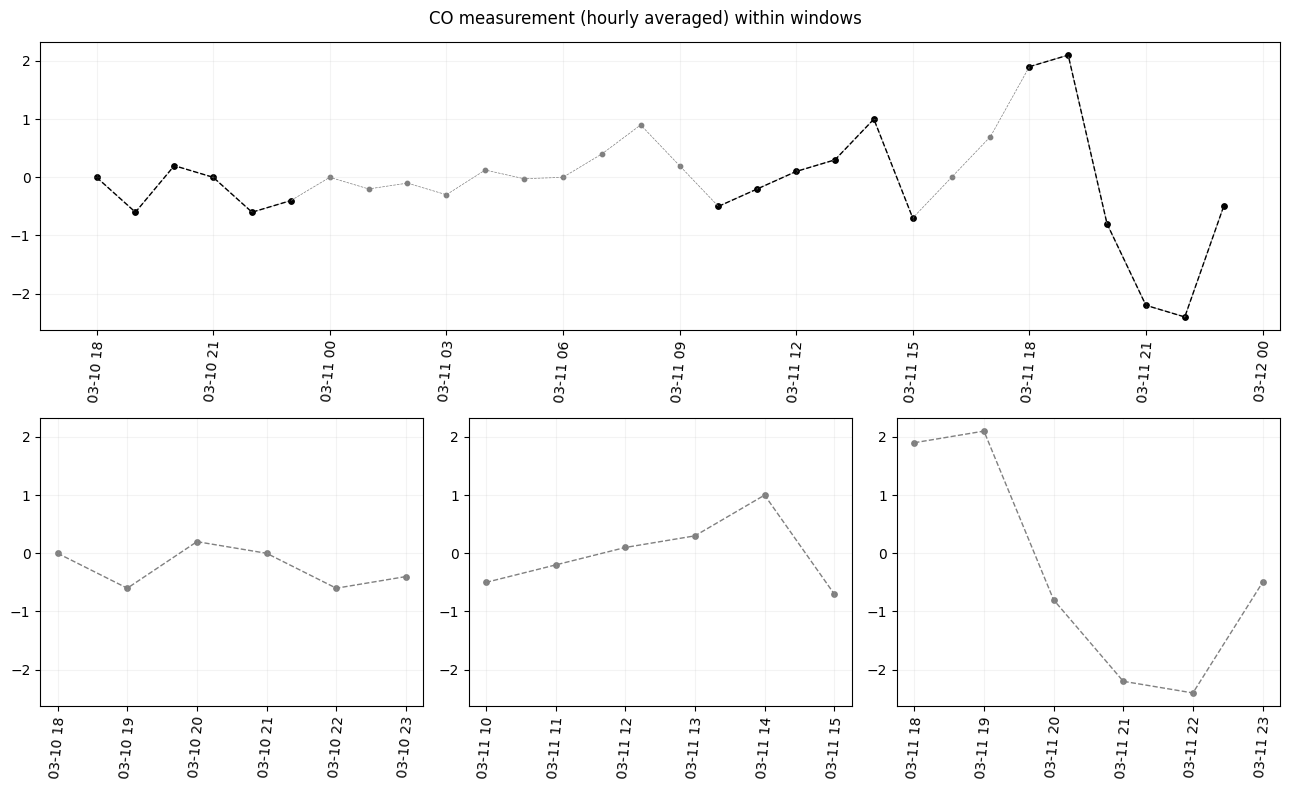

In [319]:
#| output: true

fig = plt.figure(figsize=(13, 8))
axes = []

ax = plt.subplot(211)
axes.append(ax)

dt, co_diff = get_CO_diff_at(0, 5*WINDOW_WIDTH)
ax.scatter(dt, co_diff, s=10, color="grey")
ax.plot(dt, co_diff, linewidth=.5, linestyle="dashed", color="grey")

dt, co_diff = get_CO_diff_at(0)
ax.scatter(dt, co_diff, s=15, color="k")
ax.plot(dt, co_diff, linewidth=1, linestyle="dashed", color="k")

dt, co_diff = get_CO_diff_at(WINDOW_WIDTH+10)
ax.scatter(dt, co_diff, s=15, color="k")
ax.plot(dt, co_diff, linewidth=1, linestyle="dashed", color="k")

dt, co_diff = get_CO_diff_at(4*WINDOW_WIDTH)
ax.scatter(dt, co_diff, s=15, color="k")
ax.plot(dt, co_diff, linewidth=1, linestyle="dashed", color="k")


ax = plt.subplot(234, sharey=axes[0])
axes.append(ax)
dt, co_diff = get_CO_diff_at(0)
outliers_idc = detect_outliers(co_diff)
ax.scatter(dt, co_diff, s=15, color="grey")
ax.scatter(dt.iloc[outliers_idc], co_diff.iloc[outliers_idc], s=50, color="none", edgecolor="red")
ax.plot(dt, co_diff, linewidth=1, linestyle="dashed", color="grey")

ax = plt.subplot(235, sharey=axes[0])
axes.append(ax)
dt, co_diff = get_CO_diff_at(WINDOW_WIDTH+10)
outliers_idc = detect_outliers(co_diff)
ax.scatter(dt, co_diff, s=15, color="grey")
ax.scatter(dt.iloc[outliers_idc], co_diff.iloc[outliers_idc], s=50, color="none", edgecolor="red")
ax.plot(dt, co_diff, linewidth=1, linestyle="dashed", color="grey")

ax = plt.subplot(236, sharey=axes[0])
axes.append(ax)
dt, co_diff = get_CO_diff_at(4*WINDOW_WIDTH)
outliers_idc = detect_outliers(co_diff)
ax.scatter(dt, co_diff, s=15, color="grey")
ax.scatter(dt.iloc[outliers_idc], co_diff.iloc[outliers_idc], s=50, color="none", edgecolor="red")
ax.plot(dt, co_diff, linewidth=1, linestyle="dashed", color="grey")

for ax in axes:
	ax.tick_params("x", rotation=85)
	ax.grid(alpha=.15)

plt.suptitle("CO measurement (hourly averaged) within windows")
plt.tight_layout()
plt.show()

In [320]:
X_filtered[:5*WINDOW_WIDTH]

,Datetime,CO,CO_diff
0,2004-03-10 18:00:00,2.600,0.000
1,2004-03-10 19:00:00,2.000,-0.600
2,2004-03-10 20:00:00,2.200,0.200
3,2004-03-10 21:00:00,2.200,0.000
4,2004-03-10 22:00:00,1.600,-0.600
5,2004-03-10 23:00:00,1.200,-0.400
6,2004-03-11 00:00:00,1.200,0.000
7,2004-03-11 01:00:00,1.000,-0.200
8,2004-03-11 02:00:00,0.900,-0.100
9,2004-03-11 03:00:00,0.600,-0.300


In [321]:
outlier_indices = []

dt, co_diff = get_CO_diff_at(0)
outliers_idc = detect_outliers(co_diff)
outlier_indices.extend(outliers_idc)

slides = np.arange(1, len(X_filtered)-WINDOW_WIDTH)

for i in slides:
	print(i, i+WINDOW_WIDTH)
	dt, co_diff = get_CO_diff_at(i)
	outlier = is_outlier(co_diff, co_diff.iloc[len(co_diff) - 1])
	if outlier:
		outlier_idx = co_diff.index[len(co_diff) - 1]
		outlier_indices.append(outlier_idx)

outlier_indices = np.array(outlier_indices)

1 7
2 8
3 9
4 10
5 11
6 12
7 13
8 14
9 15
10 16
11 17
12 18
13 19
14 20
15 21
16 22
17 23
18 24
19 25
20 26
21 27
22 28
23 29
24 30
25 31
26 32
27 33
28 34
29 35
30 36
31 37
32 38
33 39
34 40
35 41
36 42
37 43
38 44
39 45
40 46
41 47
42 48
43 49
44 50
45 51
46 52
47 53
48 54
49 55
50 56
51 57
52 58
53 59
54 60
55 61
56 62
57 63
58 64
59 65
60 66
61 67
62 68
63 69
64 70
65 71
66 72
67 73
68 74
69 75
70 76
71 77
72 78
73 79
74 80
75 81
76 82
77 83
78 84
79 85
80 86
81 87
82 88
83 89
84 90
85 91
86 92
87 93
88 94
89 95
90 96
91 97
92 98
93 99
94 100
95 101
96 102
97 103
98 104
99 105
100 106
101 107
102 108
103 109
104 110
105 111
106 112
107 113
108 114
109 115
110 116
111 117
112 118
113 119
114 120
115 121
116 122
117 123
118 124
119 125
120 126
121 127
122 128
123 129
124 130
125 131
126 132
127 133
128 134
129 135
130 136
131 137
132 138
133 139
134 140
135 141
136 142
137 143
138 144
139 145
140 146
141 147
142 148
143 149
144 150
145 151
146 152
147 153
148 154
149 155
150 156
151 

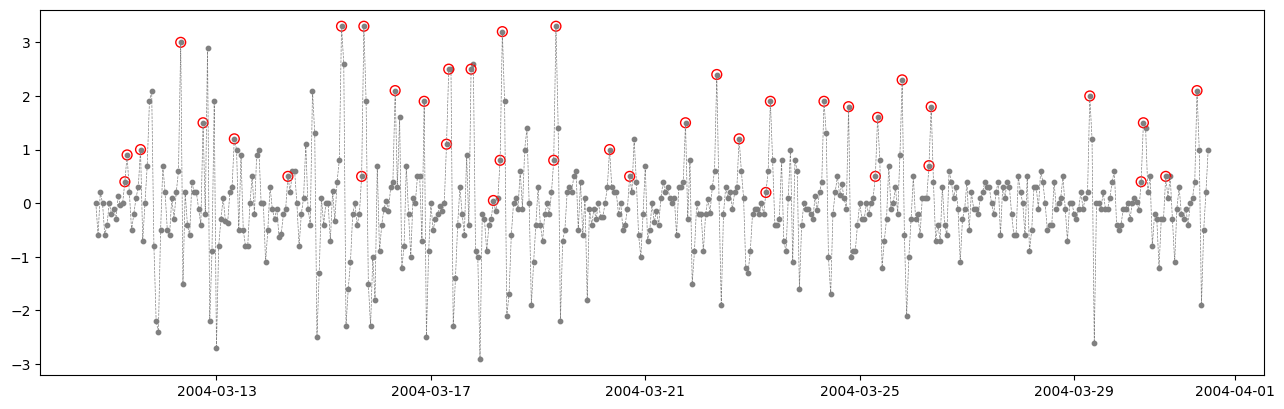

In [322]:
#| output: true

fig = plt.figure(figsize=(13, 8))
axes = []

ax = plt.subplot(211)
axes.append(ax)

dt, co_diff = get_CO_diff_at(0, 499)
ax.scatter(dt, co_diff, s=10, color="grey")
ax.scatter(dt.loc[outlier_indices], co_diff.loc[outlier_indices], s=50, color="none", edgecolor="red")
ax.plot(dt, co_diff, linewidth=.5, linestyle="dashed", color="grey")



plt.tight_layout()
plt.show()

Methodology:


In [323]:
predictorCODiff.loc[keep_indices].loc[:WINDOW_WIDTH].mean()

NameError: name 'keep_indices' is not defined

In [ ]:
import numpy as np
from scipy import stats

def detect_anomalies_ttest(data, window_size=50, alpha=0.01):
    diffs = np.diff(data)
    anomalies = np.zeros(len(data), dtype=bool)
    p_values = np.ones(len(data))
    
    for i in range(window_size, len(diffs)):
        window = diffs[i-window_size:i]
        current_diff = diffs[i]
        t_statistic, p_value = stats.ttest_1samp(window, current_diff, alternative='less')
        p_values[i+1] = p_value
        if p_value < alpha and current_diff > np.mean(window):
            anomalies[i+1] = True
    
    return anomalies, p_values

In [ ]:
data = predictorCO.values
anomalies, p_values = detect_anomalies_ttest(data, window_size=50, alpha=0.01)

In [ ]:
np.unique(anomalies, return_counts=True)

In [ ]:
anomaly_idc = predictorCO[anomalies].index
anomaly_idc.shape

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

WINDOW_WIDTH = 100


# plot CO records by datetime
ax = axes[0]
ax.scatter(X_filtered[predictorCO != -1]['Datetime'], predictorCO[predictorCO != -1], s=10, color="royalblue")
ax.scatter(X_filtered.loc[anomaly_idc][predictorCO != -1]['Datetime'], predictorCO.loc[anomaly_idc][predictorCO != -1], s=10, color="red")
ax.plot(X_filtered[predictorCO != -1]['Datetime'], predictorCO[predictorCO != -1], linewidth=.5, linestyle="dashed", color="royalblue")
ax.set_title(f"CO (hourly averaged)")
ax.tick_params("x", rotation=45)
ax.grid(alpha=.15)
ax.set_xlabel("T (date/hour)")